In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import operator
import math
import hashlib
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
"""
Read csv file into DataFrame
Parameters: Path of csv file
Returns: Pandas DataFrame 
"""  
def load_data(csv_path):
    return pd.read_csv(csv_path)

In [3]:
#load D9.csv into dataframe object
q3_data = load_data("dataset/D9.csv")

#have a look at the info of the data
q3_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 8 columns):
Unnamed: 0    2254 non-null int64
1             2254 non-null float64
2             2254 non-null float64
3             2254 non-null float64
4             2254 non-null float64
5             2254 non-null float64
6             2254 non-null float64
7             2254 non-null int64
dtypes: float64(6), int64(2)
memory usage: 141.0 KB


In [4]:
#have a look at the data
q3_data.head()

,Unnamed: 0,1,2,3,4,5,6,7
0,0,0.280307,0.277583,-0.918427,0.018825,0.020021,0.010556,1
1,1,0.094425,0.207830,-0.968575,0.072191,0.061208,0.028209,0
2,2,0.061331,0.105566,-0.982372,0.098648,0.098378,0.025084,0
3,3,0.322497,0.312729,-0.893405,0.001643,0.004185,0.001740,1
4,4,0.298441,0.263278,-0.917370,0.003255,0.005779,0.002387,1


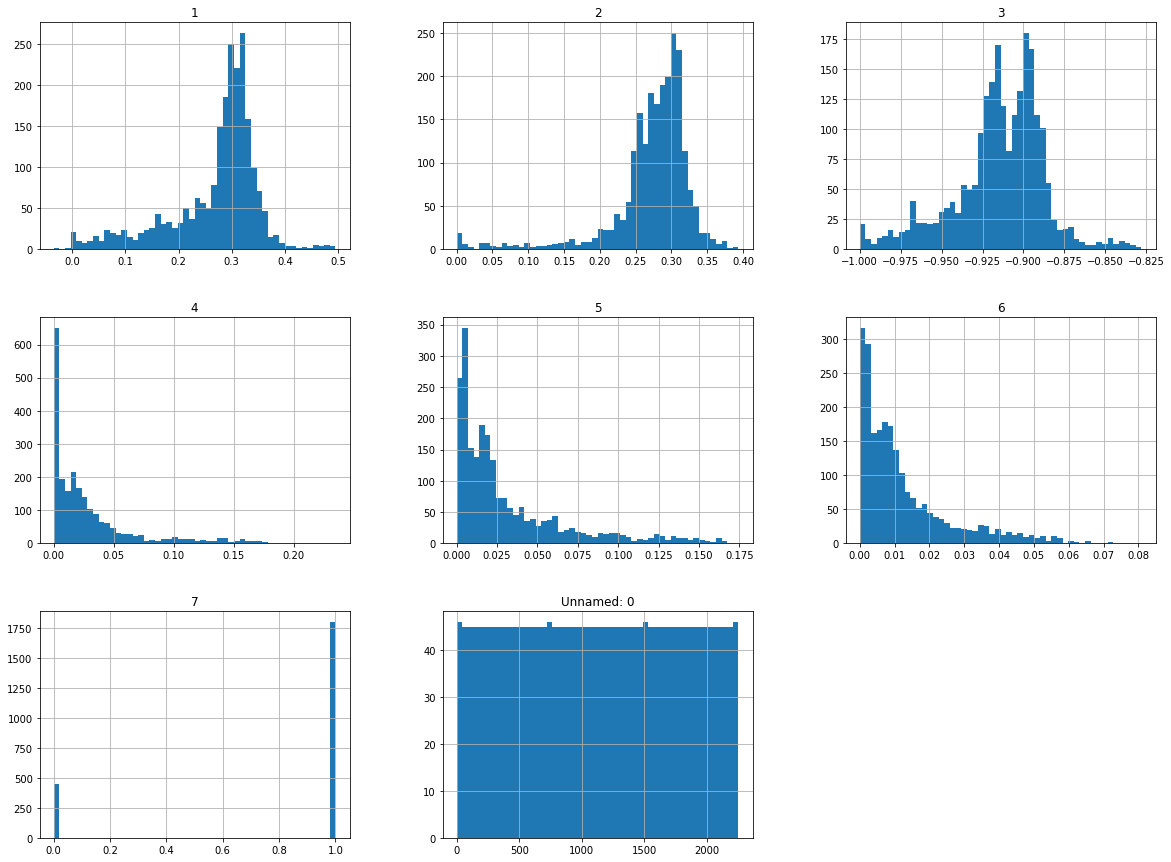

In [5]:
#plot the data to know about distribution of the data
q3_data.hist(bins = 50, figsize = (20,15))
plt.show()

In [6]:
#rename the unnamed column as 'id'
q3_data.rename(columns={'Unnamed: 0':'id'}, inplace=True)

In [7]:
#have a look at the data now
q3_data.head()

,id,1,2,3,4,5,6,7
0,0,0.280307,0.277583,-0.918427,0.018825,0.020021,0.010556,1
1,1,0.094425,0.207830,-0.968575,0.072191,0.061208,0.028209,0
2,2,0.061331,0.105566,-0.982372,0.098648,0.098378,0.025084,0
3,3,0.322497,0.312729,-0.893405,0.001643,0.004185,0.001740,1
4,4,0.298441,0.263278,-0.917370,0.003255,0.005779,0.002387,1


In [8]:
#store the value to be predicted in labels
labels = q3_data["7"].copy()

#remove column 7 from the dataset and store the remaining dataset in 'data'
data = q3_data.drop("7",axis=1)
#have a look at the 'data'
data.head()

,id,1,2,3,4,5,6
0,0,0.280307,0.277583,-0.918427,0.018825,0.020021,0.010556
1,1,0.094425,0.207830,-0.968575,0.072191,0.061208,0.028209
2,2,0.061331,0.105566,-0.982372,0.098648,0.098378,0.025084
3,3,0.322497,0.312729,-0.893405,0.001643,0.004185,0.001740
4,4,0.298441,0.263278,-0.917370,0.003255,0.005779,0.002387


In [9]:
#have a look at the labels
print(labels.head())

0    1
1    0
2    0
3    1
4    1
Name: 7, dtype: int64


In [ ]:
#Get correlation of all the columns with column 7
corr_matrix = q3_data.corr()
corr_matrix["7"].sort_values(ascending=False)

#giving very less correlation values, not much useful

7     1.000000
2     0.114751
1     0.098540
id    0.022240
3     0.000601
5    -0.405060
6    -0.419292
4    -0.423992
Name: 7, dtype: float64

In [ ]:
#Plot scatter matrix to see correlation among all the columns
attributes = ["1","2","3","4","5","6"]
scatter_matrix(q3_data[attributes],figsize=(12,8),alpha=.1)

#as we can see in plots below 4,5,6 are highly correlated(linearly dependent)
#also 1 and 3 are correlated linearly

In [ ]:
#Method to split data into training and test sets
def test_set_check(identifier,test_ratio,hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1]  < 51

def split_train_test_by_id(data,test_ratio,id_column,hash):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:test_set_check(id_,test_ratio,hash))
    return in_test_set

In [ ]:
#Split dataset into training and test_set using column 'id'
q3_data = q3_data.reset_index()
test_set_index = split_train_test_by_id(q3_data,0.66,"id",hashlib.md5)
test_set = q3_data[test_set_index]
train_set = q3_data[~test_set_index]

#delete id column from training and test set
del train_set["id"]
del test_set["id"]

In [ ]:
#Convert train set into matrix
train_set_matrix = train_set.as_matrix()

#Store a copy of test_set
test_set_copy = test_set.copy()

#delete column 7 from test set
del test_set["7"]

#Convert test set into matrix
test_set_matrix = test_set.as_matrix()

In [ ]:
#Methods for nearest neighbor 
"""
Calculate euclidean distance between two instances as
the square root of the sum of the squared differences between the two arrays of numbers
Parameters:
instance1, instance2 : instances of training and test set
length: fixed length limit for euclidean distance
"""
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

"""
Calculate k most similar neighbors from the training set for a given test instance
Parameters:
trainingSet : the training set matrix
testInstance : instance of the test set matrix
k : number of neighbors to be considered
Returns: list of k most similar neighbors
"""
def getNeighbors(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance)
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

"""
Get the majority voted response from a number of neighbors
Parameters:
neighbors - list of similar neighbors
Returns: predicted neighbor based on majority vote
"""
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

In [ ]:
#Nearest Neighbor
k=1
pred=[]
for x in range(len(test_set_matrix)):
    neighbors = getNeighbors(train_set_matrix,test_set_matrix[x],k)
    result = getResponse(neighbors)
    pred.append(result)

In [ ]:
"""
calculate accuracy of the model
Parameters:
testSet - test_set matrix with output labels
predictions - label predicted by model
Returns: accuracy %
"""
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

In [ ]:
#Convert test_set_copy into matrix
test_set_copy = test_set_copy.as_matrix()

#Calculate accuracy of the model
accuracy = getAccuracy(test_set_copy,pred)

print("Accuracy: ",accuracy, "%")

In [ ]:
"""
Calculate F1 score of the model
Parameters:
tags - list of actual label
predicted - list of label predicted by the model
Returns: F1 score
"""
def F1_score(tags,predicted):
    tags = set(tags)
    predicted = set(predicted)

    tp = len(tags & predicted)
    fp = len(predicted) - tp 
    fn = len(tags) - tp
    if tp>0:
        precision = float(tp) / (tp + fp)
        recall = float(tp) / (tp + fn)
        print("Precision: ", precision, "Recall: ", recall)

        return 2 * ((precision * recall) / (precision + recall))
    else:
        return 0

In [ ]:
#Store actual labels in tags
tags = []
for x in range(len(test_set_copy)):
    tags.append(test_set_copy[x][-1])
    
#Calculate F1 score
f1_score = F1_score(tags,pred)
print("F1 Score: ", f1_score)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(tags, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_auc_score(tags, pred))

In [ ]:
def precision(y_true, y_pred):
    i = set(y_true).intersection(y_pred)
    len1 = len(y_pred)
    if len1 == 0:
        return 0
    else:
        return len(i) / len1
    
print(precision(tags, pred))

def recall(y_true, y_pred):
    i = set(y_true).intersection(y_pred)
    return len(i) / len(y_true)

print(recall(y_test, y_pred))

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)
    
print(f1(y_test, y_pred))